In [101]:
import pandas as pd
import numpy as np
from kiteconnect import KiteConnect, KiteTicker
import login
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import time
import pytz
import pymongo
import threading
import os

In [102]:
# Access environment variables
user_name = os.getenv("KITE_USER_NAME")
password = os.getenv("KITE_PASSWORD")
totp = os.getenv("KITE_TOTP")
api_key = os.getenv("KITE_API_KEY")
api_secret = os.getenv("KITE_API_SECRET")

kite = KiteConnect(api_key=api_key)
request_token = login.kiteLogin(user_name, password, totp, api_key)
data = kite.generate_session(request_token, api_secret)
kite.set_access_token(data["access_token"])

In [103]:
instrument_dump = kite.instruments()   # get instruments dump from NSE
instrument_df = pd.DataFrame(instrument_dump)  # dump it to a dataframe
print(instrument_df.columns)

Index(['instrument_token', 'exchange_token', 'tradingsymbol', 'name',
       'last_price', 'expiry', 'strike', 'tick_size', 'lot_size',
       'instrument_type', 'segment', 'exchange'],
      dtype='object')


In [104]:
def getInstrumentToken(symbol):
    #return none if not found
    if len(instrument_df[(instrument_df['tradingsymbol']==symbol) & (instrument_df['exchange']=='NSE')]['instrument_token'].values)==0:
        return None
    return instrument_df[(instrument_df['tradingsymbol']==symbol) & (instrument_df['exchange']=='NSE')]['instrument_token'].values[0]

In [105]:
#get the list of finserv stocks from instrument dump
bse_stocks=pd.read_csv('bse.csv')
#keep only Financial Services stocks
bse_stocks=bse_stocks[bse_stocks['Sector Name']=='Financial Services']
#reset the index
bse_stocks.reset_index(drop=True,inplace=True)

token_list=[]
#get the security id and check if it is present in the instrument dump with exchange as NSE
for index, row in bse_stocks.iterrows():
    symbol=row['Security Id']
    # print(symbol)
    token=getInstrumentToken(symbol)
    # print(token)
    if token:
        # print(symbol,token)
        token_list.append(token)
    else:
        # print('Token not found for symbol:',symbol)
        #remove the row from the dataframe
        bse_stocks.drop(index,inplace=True)

#add token list to the dataframe
bse_stocks['Token']=token_list
#remove if Industry == Mutual Fund Scheme - ETF
final_env=bse_stocks[bse_stocks['Industry']!='Mutual Fund Scheme - ETF'].copy()
#reset the index
final_env.reset_index(drop=True,inplace=True)
#set the index to 'Security Id'
final_env.set_index('Security Id',inplace=True)
#first sort accourding to 'Security Id' and then 'Industry'
final_env.sort_values(by=['Industry','Security Id'],inplace=True)
print(final_env)

             Security Code                                 Issuer Name  \
Security Id                                                              
ABSLAMC             543374           Aditya Birla Sun Life AMC Limited   
HDFCAMC             541729       HDFC Asset Management Company Limited   
IVC                 511208            IL & FS Investment Managers Ltd.   
NAM-INDIA           540767  NIPPON LIFE INDIA ASSET MANAGEMENT LIMITED   
UTIAMC              543238        UTI Asset Management Company Limited   
...                    ...                                         ...   
MOTILALOFS          532892    Motilal Oswal Financial Services Limited   
NUVAMA              543988            Nuvama Wealth Management Limited   
ONELIFECAP          533632                Onelife Capital Advisors Ltd   
SHAREINDIA          540725              Share India Securities Limited   
SMCGLOBAL           543263               SMC Global Securities Limited   

                                     

In [106]:
def calculate_moment_score(df):
    if len(df) < 2:
        return np.nan
    # Get the pct change from the first to the last value
    pct_change = (df['close'].iloc[-1] / df['close'].iloc[0] - 1)
    # Get the std of pct change
    pct_change_std = np.std(df['close'].pct_change())
    if pct_change_std == 0:
        return np.nan
    score_value = pct_change / pct_change_std
    return score_value


#fuction to get zscore accourding to each column
def get_zscore(df):
    for column in df.columns:
        # print(df[column])
        df[column] = (df[column] - df[column].mean())/df[column].std()
    return df
    

def get_moment_score(df,date):
        moment_dict = {}
        # print(df.head(10))
        symbollist = df.index.to_list()
        # print(symbollist)
        end_date = datetime.strptime(date, '%Y-%m-%d')
        start_date = end_date - relativedelta(years=1)
        start_date = start_date.strftime('%Y-%m-%d')

        for symbol in symbollist:
            # print(symbol)

            try:
                stock_data = kite.historical_data(getInstrumentToken(symbol), start_date, end_date, "day")
                #make dataframe of the stock data
                stock_data = pd.DataFrame(stock_data)
                data_points = len(stock_data)
                six_month = stock_data.tail(data_points//2)
                data_points = len(six_month)
                three_month = six_month.tail(data_points//2)
                data_points = len(three_month)
                one_month = three_month.tail(data_points//3)
                data_points = len(one_month)
                two_week = one_month.tail(data_points//2)
                data_points = len(two_week)
                one_week = stock_data.tail(5)


                score_1y=calculate_moment_score(stock_data)
                socre_6m = calculate_moment_score(six_month)
                score_3m = calculate_moment_score(three_month)
                score_1m = calculate_moment_score(one_month)
                score_2w = calculate_moment_score(two_week)
                score_1w = calculate_moment_score(one_week)

                # print(socre_t,score_3m,score_1m,score_2w,score_1w,score_3d)

                row={'score_1y':score_1y,'score_6m':socre_6m,'score_3m':score_3m,'score_1m':score_1m,'score_2w':score_2w,'score_1w':score_1w}
                moment_dict[symbol] = row

            except:
                # print("Error in getting data for symbol: ", symbol)
                moment_dict[symbol] = {"Z_score_t": np.nan, "Z_score_3m": np.nan, "Z_score_1m": np.nan, "Z_score_2w": np.nan, "Z_score_1w": np.nan, "Z_score_3d": np.nan}

        moment_score_results = pd.DataFrame(moment_dict).T
        # print(moment_score_results)
        moment_score_results = get_zscore(moment_score_results)
        return moment_score_results
        # df['Moment Score'] = moment_score_results['Moment_score']

        # return df

# get the moment score for the stocks
date='2024-11-11'
moment_score_df = get_moment_score(final_env,date)

In [107]:
final_env.loc[:, 'Industry'] = final_env['Industry'].str.strip()
final_env.loc[:, 'Igroup Name'] = final_env['Igroup Name'].str.strip()

moment_score_df['Industry']=final_env['Industry']
moment_score_df['Igroup Name']=final_env['Igroup Name']
print(moment_score_df)


            score_1y  score_6m  score_3m  score_1m  score_2w  score_1w  \
ABSLAMC     1.040362  1.253140  0.491877  1.499453 -0.050575 -0.090279   
HDFCAMC     0.957408  0.286381  0.446899  0.081048 -0.052136 -0.068214   
IVC        -0.091305 -0.135716 -1.018039  0.533163  0.545512 -0.099134   
NAM-INDIA   0.823949  0.330066  0.331705  0.210143  0.187018 -0.083247   
UTIAMC      1.297588  1.737183  1.143398  0.823417  0.332780 -0.081452   
...              ...       ...       ...       ...       ...       ...   
MOTILALOFS  3.506312  1.365616  2.045607  0.720139  0.034001 -0.069327   
NUVAMA      1.813600  0.887041  0.400546  0.246503  0.086262 -0.080514   
ONELIFECAP -0.459599  0.107279  0.585661  1.797351  0.925131 -0.052624   
SHAREINDIA -1.003215 -0.887414 -0.259483 -1.420218 -0.534209 -0.083707   
SMCGLOBAL   0.411831 -0.730155 -0.088983 -0.572553  0.295536 -0.067508   

                            Industry      Igroup Name  
ABSLAMC     Asset Management Company  Capital Markets  

In [160]:
#calulate beta for each stock
def get_beta(stock_df, market_df):
    try:
        stock_df['Returns'] = stock_df['close'].pct_change()

        market_df['Market Returns'] = market_df['close'].pct_change()

        stock_df = stock_df.dropna()
        stock_df = stock_df.reset_index(drop=True)

        market_df = market_df.dropna()
        market_df = market_df.reset_index(drop=True)

        beta = np.cov(stock_df['Returns'], market_df['Market Returns'])[0][1] / np.var(market_df['Market Returns'])
    except:
        beta = np.nan
    # print(beta)
    return beta

def calculate_returns(stock_df):
    if stock_df.empty or 'close' not in stock_df.columns or len(stock_df) < 2:
        return None
    stock_return = stock_df['close'].iloc[-1] / stock_df['close'].iloc[0] - 1
    return stock_return

def calculate_expected_returns(beta,market_return):
    rfr=0.07
    expected_return=rfr+beta*(market_return-rfr)
    return expected_return

def calculate_risk_std(stock_df):
    if stock_df.empty or 'close' not in stock_df.columns or len(stock_df) < 2:
        return None
    stock_return = stock_df['close'].pct_change()
    stock_return_std = np.std(stock_return)
    return stock_return_std


def get_beta_score(df,date):
        
    # print(df.head(10))
    symbollist = df.index.to_list()
    # print(symbollist)
    end_date = datetime.strptime(date, '%Y-%m-%d')
    start_date = end_date - relativedelta(years=1)
    start_date = start_date.strftime('%Y-%m-%d')

    beta_dict={}
    i=0

    one_year_market_data = kite.historical_data(getInstrumentToken('NIFTY 50'), start_date, end_date, "day")
    #make dataframe of the stock data
    one_year_market_data = pd.DataFrame(one_year_market_data)
    data_points = len(one_year_market_data)
    six_month_market_data = one_year_market_data.tail(data_points//2)
    data_points = len(six_month_market_data)
    three_month_market_data = six_month_market_data.tail(data_points//2)
    data_points = len(three_month_market_data)
    one_month_market_data = three_month_market_data.tail(data_points//3)
    data_points = len(one_month_market_data)
    two_week_market_data = one_month_market_data.tail(data_points//2)
    data_points = len(two_week_market_data)
    one_week_market_data = one_month_market_data.tail(5)

    #calulate returns for each time period
    market_return_1y=calculate_returns(one_year_market_data)
    market_return_6m=calculate_returns(six_month_market_data)
    market_return_3m=calculate_returns(three_month_market_data)
    market_return_1m=calculate_returns(one_month_market_data)
    market_return_2w=calculate_returns(two_week_market_data)
    market_return_1w=calculate_returns(one_week_market_data)    

    market_returns={'market_return_1y':market_return_1y,'market_return_6m':market_return_6m,'market_return_3m':market_return_3m,'market_return_1m':market_return_1m,'market_return_2w':market_return_2w,'market_return_1w':market_return_1w}    

    data_points = len(one_year_market_data)
    for symbol in symbollist:
        # print(symbol)
        one_year_stock_data = kite.historical_data(getInstrumentToken(symbol), start_date, end_date, "day")
        #make dataframe of the stock data
        one_year_stock_data = pd.DataFrame(one_year_stock_data)
        data_points = len(one_year_stock_data)



        #6 month data
        six_month_stock_data = one_year_stock_data.tail(data_points//2)
        # data_points = len(six_month_stock_data)
        six_month_market_data = one_year_market_data.tail(data_points//2)
        data_points = len(six_month_market_data)
        #reset the index
        six_month_stock_data.reset_index(drop=True,inplace=True)
        six_month_market_data.reset_index(drop=True,inplace=True)

        #3 month data
        three_month_stock_data = six_month_stock_data.tail(data_points//2)
        # data_points = len(three_month_stock_data)
        three_month_market_data = six_month_market_data.tail(data_points//2)
        data_points = len(three_month_market_data)

        #1 month data
        one_month_stock_data = three_month_stock_data.tail(data_points//3)
        # data_points = len(one_month_stock_data)
        one_month_market_data = three_month_market_data.tail(data_points//3)
        data_points = len(one_month_market_data)

        #2 week data
        two_week_stock_data = one_month_stock_data.tail(data_points//2)
        # data_points = len(two_week_stock_data)
        two_week_market_data = one_month_market_data.tail(data_points//2)
        data_points = len(two_week_market_data)

        #1 week data
        one_week_stock_data = one_month_stock_data.tail(5)
        # data_points = len(one_week_stock_data)
        one_week_market_data = one_month_market_data.tail(5)
        data_points = len(one_week_market_data)

        one_year_beta=get_beta(one_year_stock_data,one_year_market_data)
        six_month_beta=get_beta(six_month_stock_data,six_month_market_data)
        three_month_beta=get_beta(three_month_stock_data,three_month_market_data)
        one_month_beta=get_beta(one_month_stock_data,one_month_market_data)
        two_week_beta=get_beta(two_week_stock_data,two_week_market_data)
        one_week_beta=get_beta(one_week_stock_data,one_week_market_data)

        #calculate returns for each time period
        stock_return_1y=calculate_returns(one_year_stock_data)
        stock_return_6m=calculate_returns(six_month_stock_data)
        stock_return_3m=calculate_returns(three_month_stock_data)
        stock_return_1m=calculate_returns(one_month_stock_data)
        stock_return_2w=calculate_returns(two_week_stock_data)
        stock_return_1w=calculate_returns(one_week_stock_data)

        #calulate expected returns
        expected_return_1y=calculate_expected_returns(one_year_beta,market_return_1y)
        expected_return_6m=calculate_expected_returns(six_month_beta,market_return_6m)
        expected_return_3m=calculate_expected_returns(three_month_beta,market_return_3m)
        expected_return_1m=calculate_expected_returns(one_month_beta,market_return_1m)
        expected_return_2w=calculate_expected_returns(two_week_beta,market_return_2w)
        expected_return_1w=calculate_expected_returns(one_week_beta,market_return_1w)

        risk=calculate_risk_std(three_month_stock_data)


        row={'beta_1y':one_year_beta,'beta_6m':six_month_beta,'beta_3m':three_month_beta,'beta_1m':one_month_beta,'beta_2w':two_week_beta,'beta_1w':one_week_beta,
             'stock_return_1y':stock_return_1y,'stock_return_6m':stock_return_6m,'stock_return_3m':stock_return_3m,'stock_return_1m':stock_return_1m,'stock_return_2w':stock_return_2w,'stock_return_1w':stock_return_1w,
             'expected_return_1y':expected_return_1y,'expected_return_6m':expected_return_6m,'expected_return_3m':expected_return_3m,'expected_return_1m':expected_return_1m,'expected_return_2w':expected_return_2w,'expected_return_1w':expected_return_1w,'risk':risk}
        beta_dict[symbol] = row

    beta_df=pd.DataFrame(beta_dict).T
    print(beta_df)
    return beta_df,market_returns
date='2024-11-11'

beta_score_df,market_return=get_beta_score(final_env,date)

C:\Users\imvar\AppData\Local\Temp\ipykernel_23992\2980176200.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\imvar\AppData\Local\Temp\ipykernel_23992\2980176200.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\imvar\AppData\Local\Temp\ipykernel_23992\2980176200.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

             beta_1y   beta_6m   beta_3m   beta_1m   beta_2w   beta_1w  \
ABSLAMC     1.234839  1.536911  1.367037  2.002754  1.655037  0.495868   
HDFCAMC     1.335692  1.679022  1.049120  1.527909  1.657517  2.749064   
IVC         1.010903  0.806700  0.687685  1.624420  0.419093  1.008577   
NAM-INDIA   1.302429  1.527829  1.262559  1.524240  1.596143  3.075470   
UTIAMC      0.555575  0.291139  0.348691  1.095787 -0.470450 -0.692529   
...              ...       ...       ...       ...       ...       ...   
MOTILALOFS  1.630392  1.836973  1.782029  3.716134  1.576718  1.173244   
NUVAMA      1.595126  1.780382  1.349689  1.496433  1.266427  3.013969   
ONELIFECAP  0.806955  0.638506  0.100970 -0.312191  0.745607 -0.049781   
SHAREINDIA  1.115028  1.345996  1.492181  1.517517  1.093209  1.858210   
SMCGLOBAL   0.966002  0.992944  0.894653  0.843034  1.586605  2.579848   

            stock_return_1y  stock_return_6m  stock_return_3m  \
ABSLAMC            0.727698         0.476616  

C:\Users\imvar\AppData\Local\Temp\ipykernel_23992\2980176200.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\imvar\AppData\Local\Temp\ipykernel_23992\2980176200.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\imvar\AppData\Local\Temp\ipykernel_23992\2980176200.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [110]:
def get_alpha_score(beta,market_return,stock_return):
    rfr=0.07
    expected_return=rfr+beta*(market_return-rfr)
    jensen_alpha=stock_return-expected_return
    return jensen_alpha


def calculate_alpha_score(beta_score_df,market_return):
    alpha_score={}
    for index,row in beta_score_df.iterrows():
        for time_period in ['1y','6m','3m','1m','2w','1w']:
            beta=row['beta_'+time_period]
            stock_return=row['stock_return_'+time_period]
            #market return is a dictionary
            market_returns=market_return['market_return_'+time_period]
            alpha=get_alpha_score(beta,market_returns,stock_return)
            beta_score_df.loc[index,'alpha_'+time_period]=alpha

            #calculate zscore for columns containing alpha
    zscore=get_zscore(beta_score_df[['alpha_1y','alpha_6m','alpha_3m','alpha_1m','alpha_2w','alpha_1w']])
    
    return zscore

alpha_score_df=calculate_alpha_score(beta_score_df,market_return)


C:\Users\imvar\AppData\Local\Temp\ipykernel_23992\523407524.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [114]:
#normalize the alpha and moment score
def normalize(df):
    for column in df.columns:
        for index in df.index:
            val=df.loc[index,column]
            if val==np.nan:
                df.loc[index,column]=0
            elif val>0:
                df.loc[index,column]=1+val
            else:
                df.loc[index,column]=1/(1-val)
    return df

moment_score_df=normalize(moment_score_df[['score_1y','score_6m','score_3m','score_1m','score_2w','score_1w']])
alpha_score_df=normalize(alpha_score_df[['alpha_1y','alpha_6m','alpha_3m','alpha_1m','alpha_2w','alpha_1w']])

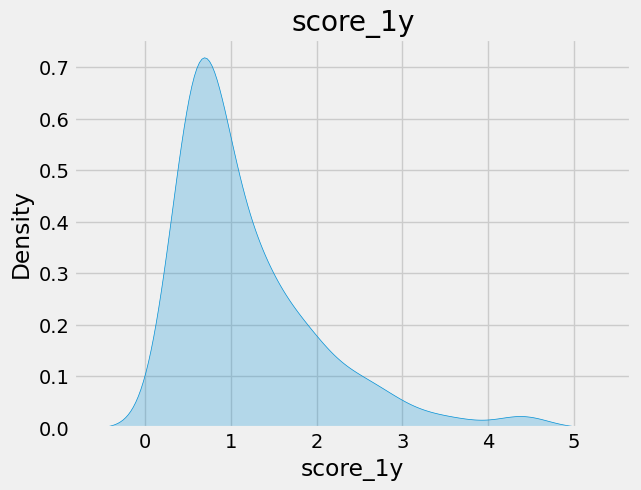

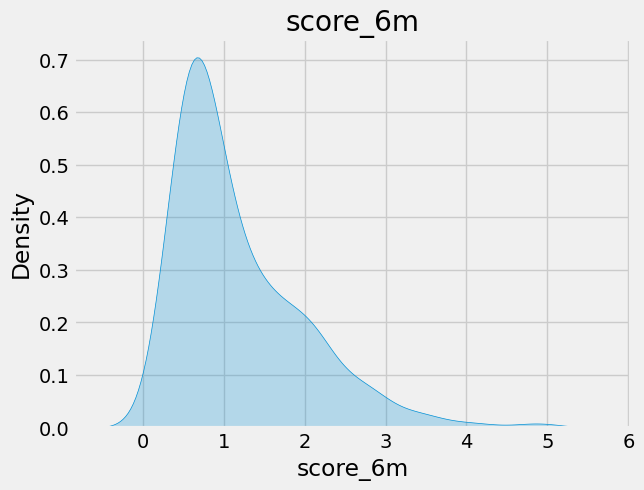

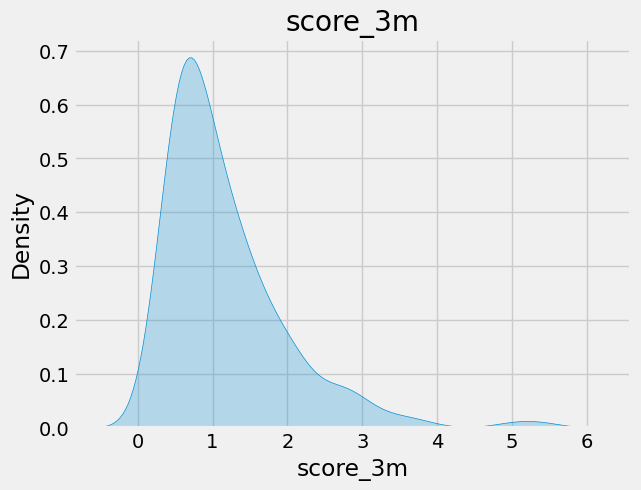

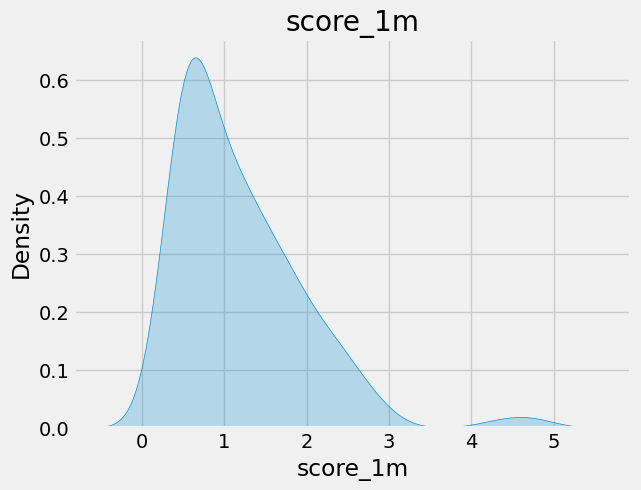

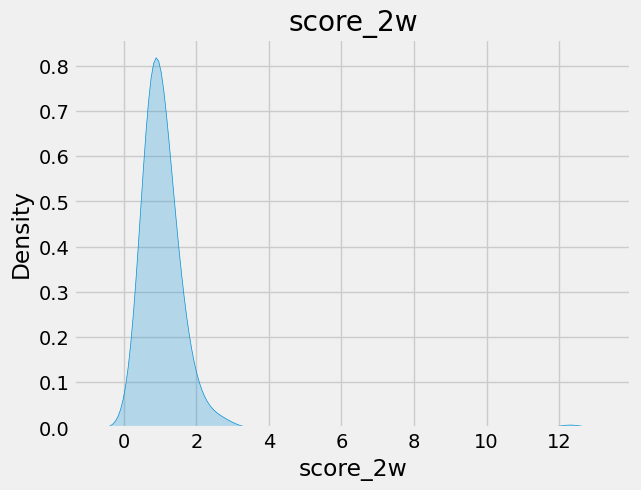

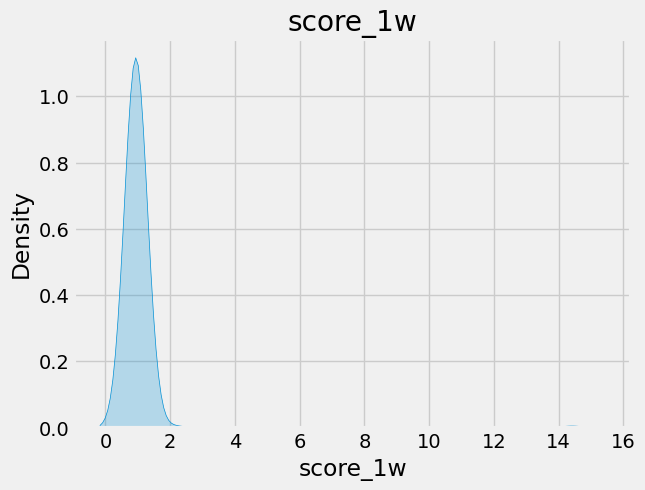

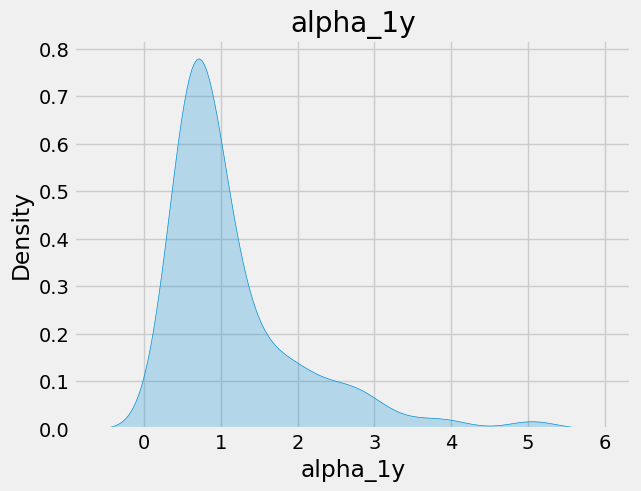

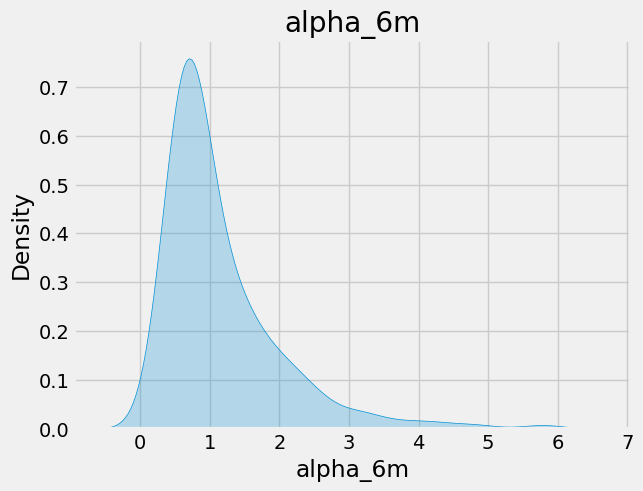

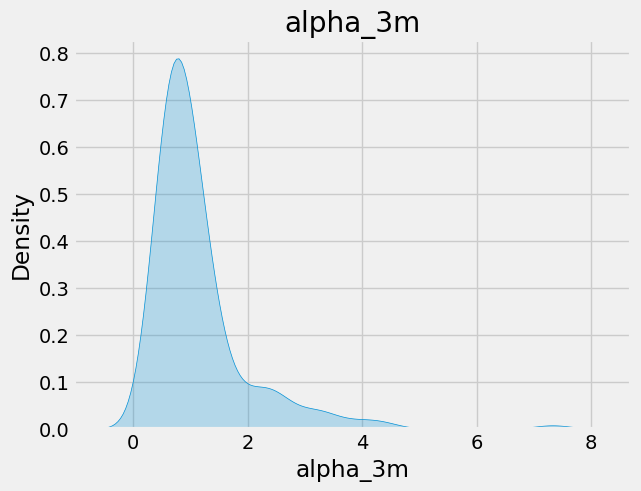

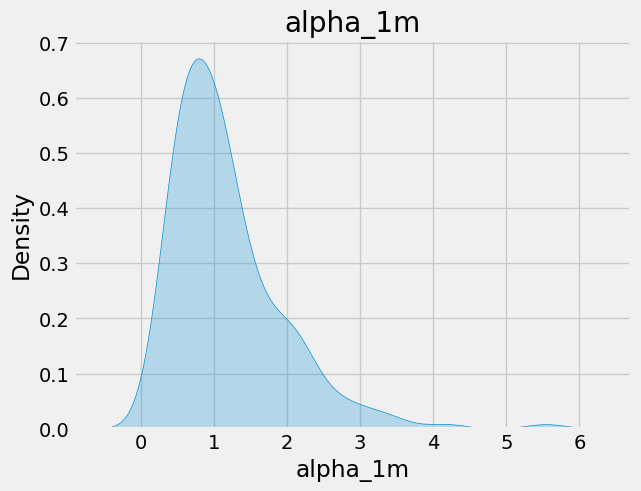

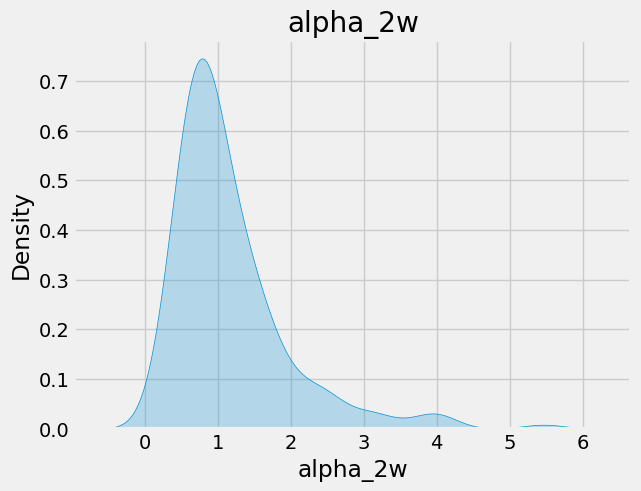

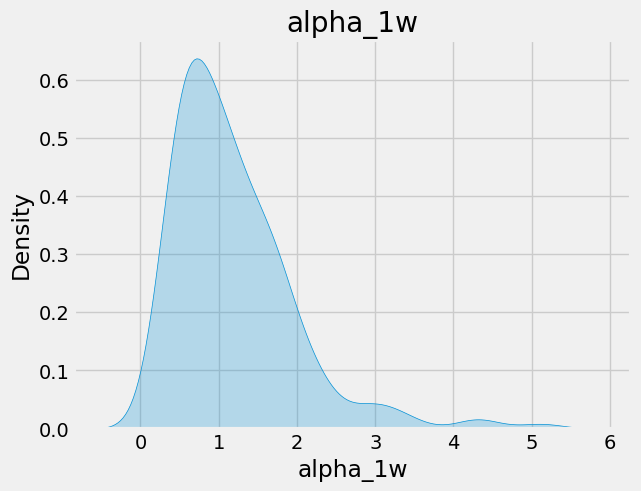

In [115]:
# Plot normal distribution for each moment score and alpha score
import seaborn as sns
import matplotlib.pyplot as plt

for column in moment_score_df.columns:
    if moment_score_df[column].dtype == 'float64':
        sns.kdeplot(moment_score_df[column], fill=True)
        plt.title(column)
        plt.show()

for column in alpha_score_df.columns:
    if alpha_score_df[column].dtype == 'float64':
        sns.kdeplot(alpha_score_df[column], fill=True)
        plt.title(column)
        plt.show()

In [116]:
#add column of alpha and moment score to the final score 
final_score_df=pd.concat([moment_score_df,alpha_score_df],axis=1)
print(final_score_df)

            score_1y  score_6m  score_3m  score_1m  score_2w  score_1w  \
ABSLAMC     2.040362  2.253140  1.491877  2.499453  0.951859  0.917196   
HDFCAMC     1.957408  1.286381  1.446899  1.081048  0.950448  0.936142   
IVC         0.916334  0.880502  0.495531  1.533163  1.545512  0.909807   
NAM-INDIA   1.823949  1.330066  1.331705  1.210143  1.187018  0.923150   
UTIAMC      2.297588  2.737183  2.143398  1.823417  1.332780  0.924683   
...              ...       ...       ...       ...       ...       ...   
MOTILALOFS  4.506312  2.365616  3.045607  1.720139  1.034001  0.935168   
NUVAMA      2.813600  1.887041  1.400546  1.246503  1.086262  0.925486   
ONELIFECAP  0.685120  1.107279  1.585661  2.797351  1.925131  0.950007   
SHAREINDIA  0.499198  0.529826  0.793976  0.413186  0.651802  0.922758   
SMCGLOBAL   1.411831  0.577983  0.918288  0.635909  1.295536  0.936761   

            alpha_1y  alpha_6m  alpha_3m  alpha_1m  alpha_2w  alpha_1w  
ABSLAMC     1.580850  2.058566  1.4114

In [118]:
#calulate final moment score as 0.3 to 1m 0.5 to 3m and 0.2 to 6m
final_score_df['final_moment_score']=0.3*final_score_df['score_1m']+0.5*final_score_df['score_3m']+0.2*final_score_df['score_6m']


#calulate final alpha score as 0.3 to 1m 0.5 to 3m and 0.2 to 6m
final_score_df['final_alpha_score']=0.3*final_score_df['alpha_1m']+0.5*final_score_df['alpha_3m']+0.2*final_score_df['alpha_6m']

#compute final score as 0.5 to final moment score and 0.5 to final alpha score
final_score_df['final_score']=0.5*final_score_df['final_moment_score']+0.5*final_score_df['final_alpha_score']

#sort the final score in descending order
final_score_df.sort_values(by='final_score',ascending=False,inplace=True)
print(final_score_df)

            score_1y  score_6m  score_3m  score_1m   score_2w  score_1w  \
JSWHL       4.339726  4.875385  5.384857  4.607076   2.659257  1.031449   
SUMMITSEC   3.496414  3.547785  3.519577  2.527543   1.826526  0.952243   
VIJIFIN     3.719523  1.464512  5.018378  4.805091  12.297518  2.125140   
PAYTM       0.568961  4.070410  2.670859  2.434092   1.525665  0.938451   
MOTILALOFS  4.506312  2.365616  3.045607  1.720139   1.034001  0.935168   
...              ...       ...       ...       ...        ...       ...   
ARMANFIN    0.424970  0.411751  0.398583  0.419967   0.653636  0.877792   
SATIN       0.389504  0.357848  0.376412  0.462903   0.961158  0.923831   
CREDITACC   0.350272  0.353787  0.363105  0.434684   0.799520  0.926683   
SPANDANA    0.336086  0.314674  0.366909  0.445545   0.854830  0.912428   
UYFINCORP   0.523882  0.782655  0.634806       NaN        NaN  0.924710   

            alpha_1y  alpha_6m  alpha_3m  alpha_1m  alpha_2w  alpha_1w  \
JSWHL       5.079262  5.7

In [157]:
#select top 20 stocks
final_list=final_score_df.head(30)

#print the columns of beta_score_df
print(beta_score_df.columns)

#add expected return of three months and expected return of six months to the final list
final_list['return_1m']=beta_score_df.loc[final_list.index,'stock_return_1m']
final_list['stock_return_3m']=beta_score_df.loc[final_list.index,'stock_return_3m']
final_list['stock_return_6m']=beta_score_df.loc[final_list.index,'stock_return_6m']

#add risk to the final list
final_list['risk']=beta_score_df.loc[final_list.index,'risk']

#change 6m to 1m return using compounding of stock return
final_list['return_6m']=((1+final_list['stock_return_6m'])**(1/6))-1
#change 3m to 1m return using compounding
final_list['return_3m']=((1+final_list['stock_return_3m'])**(1/3))-1
#calculate the weighted return for 1m,3m and 6m
# final_list['weighted_return']=0.3*final_list['return_1m']+0.5*final_list['return_3m']+0.2*final_list['return_6m']
# print(final_list)
final_list['weighted_return']=beta_score_df.loc[final_list.index,'stock_return_1m']

#remove stocks with negative expected 
final_list=final_list[final_list['weighted_return']>0]
#sort the final list by name of the stock
final_list.sort_index(inplace=True)
print(final_list)

Index(['beta_1y', 'beta_6m', 'beta_3m', 'beta_1m', 'beta_2w', 'beta_1w',
       'stock_return_1y', 'stock_return_6m', 'stock_return_3m',
       'stock_return_1m', 'stock_return_2w', 'stock_return_1w',
       'expected_return_1y', 'expected_return_6m', 'expected_return_3m',
       'expected_return_1m', 'expected_return_2w', 'expected_return_1w',
       'risk', 'alpha_1y', 'alpha_6m', 'alpha_3m', 'alpha_1m', 'alpha_2w',
       'alpha_1w'],
      dtype='object')
            score_1y  score_6m  score_3m  score_1m   score_2w  score_1w  \
ABSLAMC     2.040362  2.253140  1.491877  2.499453   0.951859  0.917196   
BFINVEST    1.266144  1.705725  2.407110  2.115290   1.642156  0.945245   
CARERATING  1.847179  1.868358  2.938604  2.486741   0.895167  0.920097   
CHOICEIN    4.340813  3.333967  3.334996  2.379372   1.565002  0.923906   
CRISIL      1.302454  2.086178  2.861288  4.294796   1.472375  0.941244   
DELPHIFX    0.499150  1.996033  2.597428  1.736026   1.224639  0.962742   
DHANI      

C:\Users\imvar\AppData\Local\Temp\ipykernel_23992\650461661.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\imvar\AppData\Local\Temp\ipykernel_23992\650461661.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\imvar\AppData\Local\Temp\ipykernel_23992\650461661.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [158]:
portfolio=pd.DataFrame()
for index, row in final_list.iterrows():
    # print(index)
    instrument_token = getInstrumentToken(index)
    # print(instrument_token)

    #get last one month data for each stock
    to_date = '2024-10-08'
    to_date = datetime.strptime(to_date, '%Y-%m-%d')
    from_date = to_date - timedelta(days=90)
    from_date = from_date.strftime('%Y-%m-%d')
    # print(from_date, to_date)
    data = kite.historical_data(instrument_token, from_date, to_date, 'day')
    #change the data to dataframe
    data = pd.DataFrame(data)
    data['pct_change'] = data['close'].pct_change()
    data = data[['date', 'pct_change']]
    data['date'] = pd.to_datetime(data['date'])
    data = data.set_index('date')
    # print(data)

    #push the data to portfolio
    portfolio[index] = data['pct_change']
#remove the first row of the portfolio
portfolio = portfolio.iloc[1:]
display(portfolio)
    

,ABSLAMC,BFINVEST,CARERATING,CHOICEIN,CRISIL,DELPHIFX,DHANI,DHUNINV,HDFCBANK,JSWHL,...,PAYTM,PRIMESECU,PRUDENT,SUMMITSEC,TIMESGTY,UTIAMC,VHL,VIJIFIN,VLSFINANCE,WELINV
date,,,,,,,,,,,,,,,,,,,,,
2024-07-11 00:00:00+05:30,0.021660,0.002344,0.026670,-0.001665,-0.004483,-0.019904,0.002997,0.039285,-0.002583,-0.003423,...,0.028042,0.010624,-0.000025,0.028643,0.013925,0.010031,0.006631,-0.023102,0.006548,-0.030923
2024-07-12 00:00:00+05:30,0.009779,-0.007241,-0.006211,-0.005646,0.010244,-0.019981,0.056220,-0.005685,0.000493,-0.002530,...,-0.029776,-0.001674,-0.003655,-0.003567,-0.012526,0.007885,-0.012300,-0.020270,-0.009362,0.020852
2024-07-15 00:00:00+05:30,0.030236,-0.001671,-0.021623,-0.016131,0.043527,-0.011528,0.030239,-0.014850,-0.000370,-0.006129,...,0.007941,0.005577,0.045633,0.009121,0.027740,0.015993,0.022970,-0.020690,0.002082,-0.013617
2024-07-16 00:00:00+05:30,0.015499,0.006393,-0.029281,0.010756,-0.012672,-0.012048,0.044113,-0.009195,-0.001449,0.001568,...,-0.019908,0.007834,0.009565,0.009038,0.040672,0.033969,-0.012424,-0.021127,0.002398,-0.000188
2024-07-18 00:00:00+05:30,-0.002614,-0.025560,-0.016427,0.003244,-0.035051,-0.007317,-0.056880,-0.000076,-0.003056,-0.004406,...,-0.032587,-0.044137,0.003880,-0.014790,-0.078951,-0.017581,-0.012199,-0.021583,-0.003987,-0.023787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-01 00:00:00+05:30,0.042976,0.005501,-0.008407,0.024294,-0.003861,0.019968,0.015499,0.029058,-0.003378,-0.000593,...,0.062545,-0.002205,-0.011796,0.026533,0.099850,-0.004478,0.001010,0.003597,-0.022770,0.070519
2024-10-03 00:00:00+05:30,-0.026404,-0.001770,0.030770,-0.015254,-0.032199,-0.020009,-0.037121,-0.023596,-0.025605,-0.023886,...,-0.005196,0.023757,-0.023776,-0.031892,-0.046686,0.000000,-0.028867,-0.025090,-0.038041,-0.026915
2024-10-04 00:00:00+05:30,-0.018285,0.021841,0.069186,-0.002440,-0.021346,0.010849,-0.003523,-0.038679,-0.014477,-0.033927,...,-0.044533,-0.010434,-0.018918,-0.028603,-0.012421,-0.013495,-0.004889,0.003676,-0.010999,-0.014682


In [159]:
#caluculate the correlation for portfolio
covariance = portfolio.cov()
covariance=covariance*250
print(covariance)

#get list of weighted returns for each stock
weighted_returns = final_list[['weighted_return']]
#compond it with 12 to get annual returns
# weighted_returns = ((1+weighted_returns)**12)-1
print(weighted_returns)

             ABSLAMC  BFINVEST  CARERATING  CHOICEIN    CRISIL  DELPHIFX  \
ABSLAMC     0.127231  0.045514    0.002827  0.046693  0.022702  0.016603   
BFINVEST    0.045514  0.125126    0.030907  0.041489  0.021673  0.016571   
CARERATING  0.002827  0.030907    0.096006  0.004502  0.016525  0.029120   
CHOICEIN    0.046693  0.041489    0.004502  0.067003  0.009978  0.028601   
CRISIL      0.022702  0.021673    0.016525  0.009978  0.071372  0.023392   
DELPHIFX    0.016603  0.016571    0.029120  0.028601  0.023392  0.126980   
DHANI       0.082461  0.091910    0.043086  0.056868  0.050946  0.033297   
DHUNINV     0.076483  0.061815    0.016339  0.026623  0.041711  0.060781   
HDFCBANK    0.018947  0.024888    0.002647  0.012514  0.013042  0.001358   
JSWHL       0.032381  0.057846   -0.004419  0.035657  0.019319  0.019029   
MONARCH     0.073166  0.056070    0.022929  0.040767  0.068136  0.049992   
MOTILALOFS  0.062107  0.050264    0.028261  0.047262  0.027786  0.046367   
MUTHOOTCAP  

In [143]:
#plot heatmap for covariance using plotly
import plotly.express as px
fig = px.imshow(covariance)
fig.show()

#compute correlation matrix
correlation = portfolio.corr()
fig = px.imshow(correlation)
fig.show()

In [145]:
portfolio_returns = []
portfolio_volatility = []

sharpe_ratio = []   

stock_weights = []  
num_assets = len(final_list)
num_portfolios = 100000

np.random.seed(5)
for i in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    stock_weights.append(weights)
    returns = np.dot(weights, weighted_returns['weighted_return'])
    portfolio_returns.append(returns)
    portfolio_risk=np.sqrt(np.dot(weights.T, np.dot(covariance, weights)))
    portfolio_volatility.append(portfolio_risk)

    #sharpe ratio
    sharpe = (returns-0.07)/portfolio_risk
    sharpe_ratio.append(sharpe)

In [146]:
# Storing the portfolio values
portfolio = {'Returns': portfolio_returns,
             'Volatility': portfolio_volatility,
             'Sharpe Ratio': sharpe_ratio}

# Add an additional entry to the portfolio such that each indivudal weight is incorporated for its corresponding company
for counter,symbol in enumerate(final_list.index):
    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]

# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

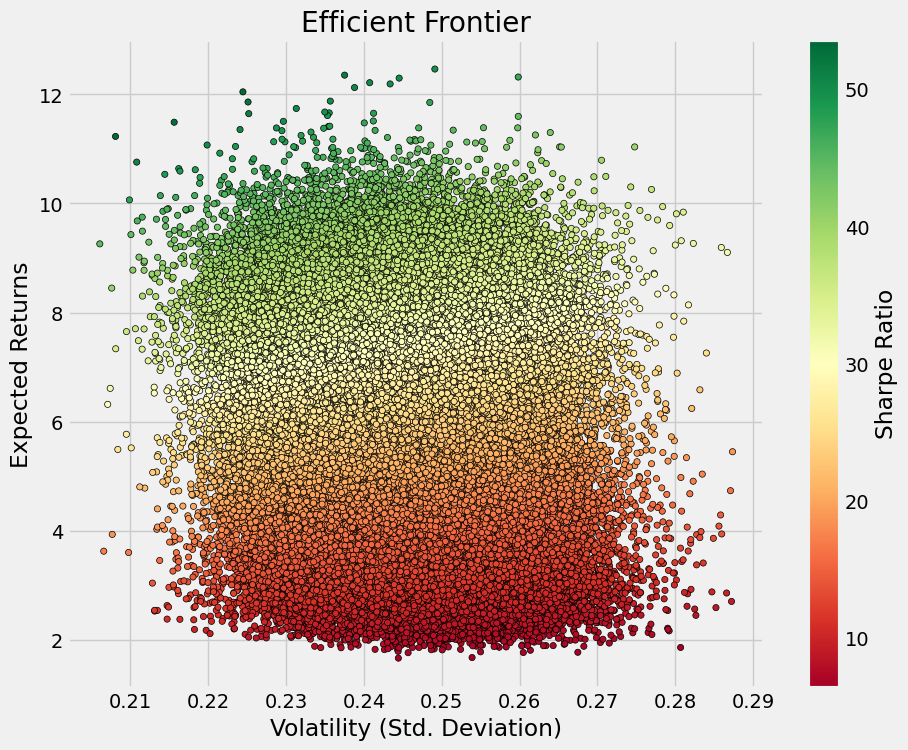

In [147]:
# PLotting the efficient frontier.
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

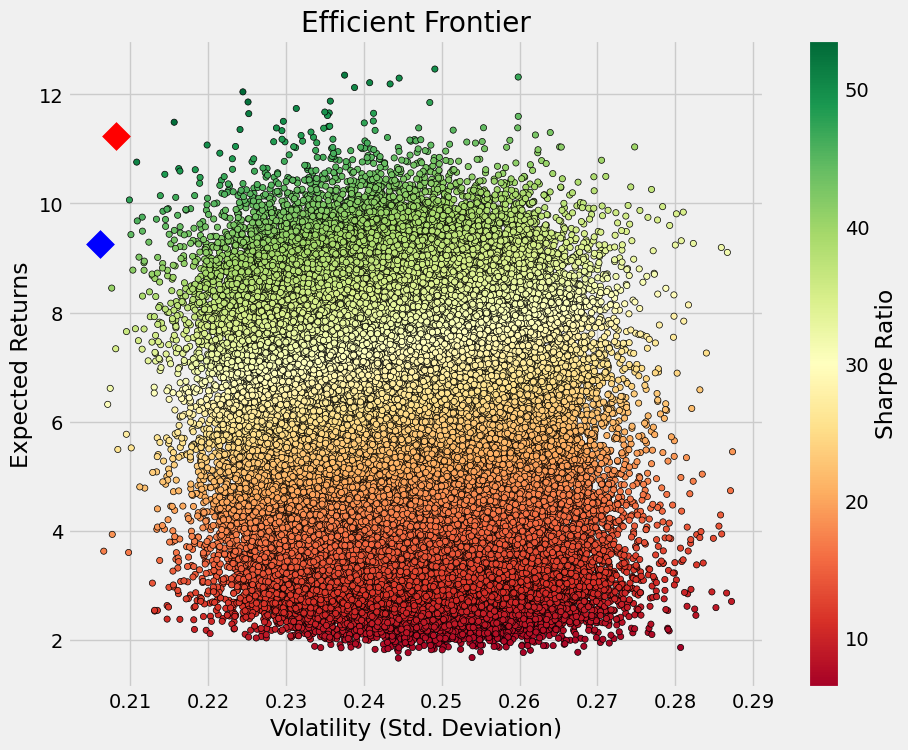

In [148]:
# Finding the Optimal Portfolio
min_volatility = df['Volatility'].min()
max_sharpe = df['Sharpe Ratio'].max()

# use the min, max values to locate and create the two special portfolios
sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
min_variance_port = df.loc[df['Volatility'] == min_volatility]

# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('fivethirtyeight')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='D', s=200)
plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='D', s=200 )
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [149]:
r_ef = pd.concat([min_variance_port.T,sharpe_portfolio.T], axis = 1)
r_ef.columns = ["Minimum Risk Adjusted Values", "Max Risk Adjusted Values"]
print(r_ef)

                   Minimum Risk Adjusted Values  Max Risk Adjusted Values
Returns                                9.259367                 11.228379
Volatility                             0.206067                  0.208087
Sharpe Ratio                          44.594034                 53.623736
ABSLAMC Weight                         0.020246                  0.008189
ARIHANTCAP Weight                      0.035781                  0.067469
BFINVEST Weight                        0.023906                  0.063522
CARERATING Weight                      0.040273                  0.071431
CHOICEIN Weight                        0.016650                  0.012034
CREST Weight                           0.009610                  0.002232
CRISIL Weight                          0.039211                  0.025412
DELPHIFX Weight                        0.057394                  0.028756
DHANI Weight                           0.024195                  0.012632
DHUNINV Weight                        

In [152]:
import scipy.optimize as sc
def portfolio_performance(weights, returns, cov_matrix):
    returns=np.sum(returns*weights)
    std=np.sqrt(np.dot(weights.T,np.dot(cov_matrix,weights)))
    return returns,std

# to get maximum sharpe ratio, we can minimize negative sharpe ratio
def negative_sharpe_ratio(weights,returns,cov_matrix,rfr=0.07):
    p_ret,p_std=portfolio_performance(weights,returns,cov_matrix)
    return -(p_ret-rfr)/p_std

def maxSR(returns,cov_matrix):
    rfr=0.07
    constraintSet=(0,1)
    num_assets=len(returns)
    args=(returns,cov_matrix,rfr)
    constraints=({'type':'eq','fun':lambda x: np.sum(x)-1})
    bound=constraintSet
    bounds=tuple(bound for asset in range(num_assets))
    #optimize using SLSQP (Sequential Least Squares Programming) algorithm
    result=sc.minimize(negative_sharpe_ratio, num_assets*[1./num_assets,],args=args,method='SLSQP',bounds=bounds,constraints=constraints)
    return result

result=maxSR(weighted_returns['weighted_return'],covariance)
print(result)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -286.1199158833767
       x: [ 8.332e-11  3.170e-10 ...  1.616e-12  2.580e-10]
     nit: 7
     jac: [ 8.131e+01  6.422e+01 ...  1.286e+02  6.558e+01]
    nfev: 192
    njev: 6


In [131]:
#multiply by 100 to get percentage and round off to 2 decimal places
display(np.round(result.x*100,2))

array([33.83,  0.  ,  7.52,  0.  , 58.65])

In [151]:
#finding global minimum variance portfolio

def portfolioVariance(weights, Returns, cov_matrix):
    return portfolio_performance(weights, Returns, cov_matrix)[1]

def minimizeVariance(meanReturns, covMatrix):
    """Minimize the portfolio variance by altering the 
     weights/allocation of assets in the portfolio"""
    constraintSet=(0,1)

    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = constraintSet
    bounds = tuple(bound for asset in range(numAssets))
    result = sc.minimize(portfolioVariance, numAssets*[1./numAssets], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

result = minimizeVariance(weighted_returns['weighted_expected_return'], covariance)

KeyError: 'weighted_expected_return'

In [133]:
print(result)
print(np.round(result.x*100,2)) 

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.2040225443996666
       x: [ 4.045e-01  2.072e-01  1.973e-01  1.089e-01  8.198e-02]
     nit: 7
     jac: [ 2.040e-01  2.037e-01  2.045e-01  2.041e-01  2.038e-01]
    nfev: 42
    njev: 7
[40.45 20.72 19.73 10.89  8.2 ]


In [134]:
def portfolioReturn(weights, meanReturns, covMatrix):
      return portfolio_performance(weights, meanReturns, covMatrix)[0]

def efficientFrontier(meanReturns, covMatrix, targetReturn):
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix)
    constraints = ({'type': 'eq', 'fun': lambda x: portfolioReturn(x, meanReturns, covMatrix) - targetReturn},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0, 1)
    bounds = tuple(bound for asset in range(numAssets))
    result = sc.minimize(portfolioVariance, numAssets*[1./numAssets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [135]:
def calculate_results(returns,covariance):
    maxSR_portfolio= maxSR(returns,covariance)
    minVar_portfolio= minimizeVariance(returns,covariance)

    maxSR_portfolio_weights = np.round(maxSR_portfolio.x*100,2)
    minVar_portfolio_weights = np.round(minVar_portfolio.x*100,2)

    maxSR_portfolio_returns, maxSR_portfolio_risk = portfolio_performance(maxSR_portfolio_weights, returns, covariance)
    minVar_portfolio_returns, minVar_portfolio_risk = portfolio_performance(minVar_portfolio_weights, returns, covariance)

    return maxSR_portfolio_weights, minVar_portfolio_weights, maxSR_portfolio_returns, maxSR_portfolio_risk, minVar_portfolio_returns, minVar_portfolio_risk

maxSR_portfolio_weights, minVar_portfolio_weights, maxSR_portfolio_returns, maxSR_portfolio_risk, minVar_portfolio_returns, minVar_portfolio_risk = calculate_results(weighted_returns['weighted_expected_return'], covariance)


print("Max Sharpe Ratio Portfolio Weights: ", maxSR_portfolio_weights)
print("Min Variance Portfolio Weights: ", minVar_portfolio_weights)
print("Max Sharpe Ratio Portfolio Returns: ", maxSR_portfolio_returns)
print("Max Sharpe Ratio Portfolio Risk: ", maxSR_portfolio_risk)
print("Min Variance Portfolio Returns: ", minVar_portfolio_returns)
print("Min Variance Portfolio Risk: ", minVar_portfolio_risk)

#add the weights to the final list
final_list['maxSR_portfolio_weights']=maxSR_portfolio_weights
final_list['minVar_portfolio_weights']=minVar_portfolio_weights

print(final_list)

Max Sharpe Ratio Portfolio Weights:  [33.83  0.    7.52  0.   58.65]
Min Variance Portfolio Weights:  [40.45 20.72 19.73 10.89  8.2 ]
Max Sharpe Ratio Portfolio Returns:  62.72070627474572
Max Sharpe Ratio Portfolio Risk:  27.836118575177686
Min Variance Portfolio Returns:  30.943424384327052
Min Variance Portfolio Risk:  20.400212597041644
          score_1y  score_6m  score_3m  score_1m   score_2w  score_1w  \
CRISIL    1.302454  2.086178  2.861288  4.294796   1.472375  0.941244   
DELPHIFX  0.499150  1.996033  2.597428  1.736026   1.224639  0.962742   
JSWHL     4.339726  4.875385  5.384857  4.607076   2.659257  1.031449   
TIMESGTY  1.875298  2.036635  1.621095  2.294803   1.605660  0.926870   
VIJIFIN   3.719523  1.464512  5.018378  4.805091  12.297518  2.125140   

          alpha_1y  alpha_6m  alpha_3m  alpha_1m  ...  final_moment_score  \
CRISIL    1.174701  1.459573  1.626181  1.234995  ...            3.136318   
DELPHIFX  0.543159  1.893294  2.300781  0.954138  ...           